# Predicting Recovery Days

In this notebook, we will be conducting some basic EDA and feature engineering to eventually construct a Multiple Linear Regression Model.

### Import the necessary modules


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from utilities.functions import *


### Load the Data

In [2]:
data = pd.read_csv('data/global_disaster_response_2018_2024 (1).csv')

In [3]:
data.head()

,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,2021-01-31,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,2018-12-23,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,2020-08-10,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,2022-09-15,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,2022-09-28,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


#### Plotting a correlation heatmap to get an idea of the relationship between covariates and the response (recovery_days)

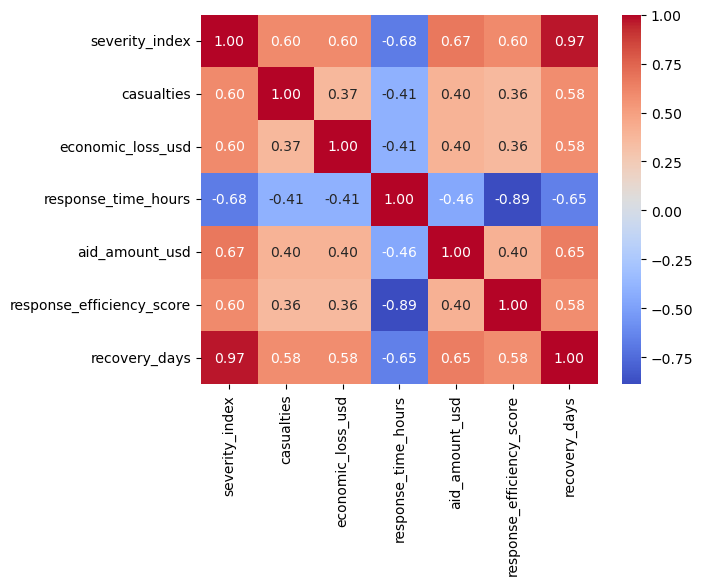

In [4]:
subset = data[['severity_index','casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days']]
corr_mat = subset.corr()
sns.heatmap(corr_mat, annot = True, fmt = ".2f", cmap = "coolwarm")
plt.savefig("figures/correlation_heatmap.png", bbox_inches='tight')

### Check the relationships of different covariates with recovery_days to check linearity

Notice that we are plotting a random, representative subset of the data (5000 rows) as opposed to the entire dataset. Plotting the entire dataset would result in overplotting, and we'd have a harder time interpretting the plots.

In [ ]:
plot_bivariate_scatter(
    data=data,
    y_column='recovery_days',
    x_columns=[
        'severity_index',
        'casualties',
        'economic_loss_usd',
        'response_time_hours',
        'aid_amount_usd',
        'response_efficiency_score'
    ],
    sample_size=5000
)
plt.savefig("figures/Bivariate_relationships.png", bbox_inches='tight')

### Apply Log transformations on the some of the covariates to linearize its relationship with recovery_days

Im also essentially inverting the meaning of response_efficiency_score as intuitvely I thought it made more sense that as the score goes up, the recovery days would go down.

In [ ]:
# Create a transformed copy
subset_tf = subset.copy()

# Apply transformations
subset_tf['severity_index_tf'] = subset_tf['severity_index']  # no transform

subset_tf['casualties_tf'] = np.log1p(subset_tf['casualties'])

subset_tf['economic_loss_usd_tf'] = np.log1p(subset_tf['economic_loss_usd'])

subset_tf['response_time_hours_tf'] = np.log1p(subset_tf['response_time_hours'])

subset_tf['aid_amount_usd_tf'] = np.log1p(subset_tf['aid_amount_usd'])

subset_tf['response_efficiency_score_tf'] = np.log1p(
    100 - subset_tf['response_efficiency_score']
)

# Keep recovery_days unchanged
subset_tf['recovery_days'] = subset_tf['recovery_days']

In [ ]:
y_column = 'recovery_days'

x_columns_tf = [
    'severity_index_tf',
    'casualties_tf',
    'economic_loss_usd_tf',
    'response_time_hours_tf',
    'aid_amount_usd_tf',
    'response_efficiency_score_tf'
]

In [ ]:
plot_bivariate_scatter(
    data=subset_tf,
    y_column=y_column,
    x_columns= x_columns_tf,
    sample_size=5000
)
plt.savefig("figures/Bivariate_tranformed_relationships.png", bbox_inches='tight')

We are observing some outliers towards the left of the plot, hence a good step would be to filter out the outliers depending on whether a data point is above or below 1.5 IQR away from the mean.

In [ ]:
# Columns to check for outliers (transformed features only)
outlier_columns = [
    'severity_index_tf',
    'casualties_tf',
    'economic_loss_usd_tf',
    'response_time_hours_tf',
    'aid_amount_usd_tf',
    'response_efficiency_score_tf'
]

subset_tf_clean = remove_iqr_outliers(
    subset_tf,
    columns=outlier_columns,
    k=1.5
)

print(f"Rows before outlier removal: {len(subset_tf)}")
print(f"Rows after outlier removal:  {len(subset_tf_clean)}")

In [ ]:
plot_bivariate_scatter(
    data=subset_tf_clean,
    y_column=y_column,
    x_columns= x_columns_tf,
    sample_size=5000
)
plt.savefig("figures/Bivariate_relationships_wo_outliers.png", bbox_inches='tight')

### Perform the train test split on the data, and fit the model on the transformed training design matrix.

In [ ]:
X = data[
    [
        'severity_index',
        'casualties',
        'economic_loss_usd',
        'response_time_hours',
        'aid_amount_usd',
        'response_efficiency_score'
    ]
]

# Response variable
y = data['recovery_days']

In [ ]:
features = [
    'severity_index',
    'casualties',
    'economic_loss_usd',
    'response_time_hours',
    'aid_amount_usd',
    'response_efficiency_score'
]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Combine X and y for convenience
train_df = X_train.copy()
train_df['recovery_days'] = y_train

test_df = X_test.copy()
test_df['recovery_days'] = y_test

# Transform features
train_tf = transform_features(train_df)
test_tf = transform_features(test_df)

# Split back
X_train_tf = train_tf[features]
y_train_tf = train_tf['recovery_days']

X_test_tf = test_tf[features]
y_test_tf = test_tf['recovery_days']


# Fit
lin_reg = LinearRegression()
lin_reg.fit(X_train_tf, y_train_tf)


### Predict using the test covariates and compare to the actual test data

In [ ]:

y_pred = lin_reg.predict(X_test_tf)

# Metrics
print(f"R²  = {r2_score(y_test_tf, y_pred):.4f}")
print(f"MSE = {mean_squared_error(y_test_tf, y_pred):.4f}")
print(f"MAE = {mean_absolute_error(y_test_tf, y_pred):.4f}")

Based on the results above, our model seems to be doing a pretty good in explaining the variance in our response according to our features!

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(
    y_test_tf,
    y_pred,
    alpha=0.6,
    edgecolors='k',
    s=25
)

# 45-degree reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Actual Recovery Days", fontsize=12)
plt.ylabel("Predicted Recovery Days", fontsize=12)
plt.title("Actual vs. Predicted Recovery Days (Linear Regression)", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)

plt.savefig("figures/actual_v_predicted.png", bbox_inches='tight')

Plotting the predicted vs actual recovery days, we can see our plot roughly following the line y = x, which is indicative of a model performing reasonably well in generalizing to the data.

In [ ]:
residuals = y_test_tf - y_pred

plt.figure(figsize=(8, 6))

plt.scatter(
    y_pred,
    residuals,
    alpha=0.6,
    edgecolors='k',
    s=25
)

plt.axhline(0, linestyle='--')

plt.xlabel("Predicted Recovery Days", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs. Predicted", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.5)

plt.savefig("figures/residuals_v_predicted.png", bbox_inches='tight')

Plotting the predictions vs the residuals, we observe pretty much no heteroskedasticity, which is also indicative of our model generalizing to the data. 